In [1]:
import numpy as np
import requests
import skimage
import skimage.data
import sonnet as snt
import tensorflow as tf
import ipywidgets as widgets
import matplotlib.pyplot as plt

keras = tf.keras
K = keras.backend

from ipywidgets import interact, interactive, Layout, HBox
from skimage.transform import rescale, warp, ProjectiveTransform
from sklearn.preprocessing import OneHotEncoder

# extra code
import helpers

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

/home/euler/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Spatial Transformer Networks

[Spatial Transformer Networks, by Jaderberg, M. et. al](https://arxiv.org/pdf/1506.02025.pdf) explores a new convolutional neural network (CNN) module designed by the authors at Google Deepmind.
It allows a network to incorporate spatial transformations, typically on the input layer, which can have the effect of cropping, reorienting, or undistorting the layer in question.
The authors show how spatial transformations can take the place of attention networks, and additionally solve previous problems with translational invariance in CNNs.
It can be added seamlessly to any neural network. 
It is differentiable, and and therefore trained through simple backpropogation.

First, let's consider the motivations behind spatial transformer networks, starting with attention mechanisms in neural architecture.

### Attention

Attention mechanisms in neural networks give them the ability to focus on subsets of features. In image processing, this takes the shape of spatial localization of the features.

![Image](img/show-attend-tell.png)

[image from Show, Attend, and Tell](https://arxiv.org/abs/1502.03044)

Why is this so effective?  Here's the intuition I could come up with: Part of it is the problem space of most testing with CNNs: Single object classification or some single object-based task. Even extending this to several objects, there is often a large amount of irrelevant background information in the images. As such, this is an effective dimensionality reduction technique. 

To contrast, it may not be effective for segmentation of a large number of objects, or for semantic segmentation tasks, or for something with extracting texture features.
In other words, tasks where you might expect important features to be comprehensively spread through the image.

In CNNs, we can consider attention in other image processing terms, taking the form of a binary or probability mask over an image (or layer), thereby focusing the effective activations within a small region.
This naive method of attention works, but with a heavy computational load. Kernels must still be computed over the whole image.

Another proposed option, is to crop the image.
However, this method also faces problems, as it so far has been non-differentiable, so some sort of stochastic or baked-in cropping method must be implemented.

As we'll see, image cropping can actually be modeled by a constrained linear transformation.


### Translational Invariance







Next, let's quickly go over basic spatial transforms.

The two important concepts involved here are:

### Spatial Transformations

For a much deeper look at these spatial transformations, [check out this resource](https://people.cs.clemson.edu/~dhouse/courses/401/notes/affines-matrices.pdf)

A "spatial transformation" is a transformation on the *coordinate system* of an image.

Let a pixel $P$ be defined at: $(x, y)$

then the transformation $T_\theta$ maps the pixel $P$ to a point $(x', y')$

The most basic forms of spatial transformations are linear or projective transformations, which can be represented with matrix multiplication.
Let's look at some examples of these matrices, to have a look at what the *parameters* of such transformations are.

##### linear

for a "rigid body" transformation, we have 3 parameters, $t_x, t_y, \theta$:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} \cos(\theta) & -\sin(\theta) & -t_x \\ \sin(\theta) & \cos(\theta) & -t_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

a "similarity" transformation, with 4 parameters $s, t_x, t_y, \theta$:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} s \cos(\theta) &  -s \sin(\theta) & -t_x \\ s \sin(\theta) & s \cos(\theta) & -t_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

for more general, "affine" transformations, 6 parameters $a, b, c, d, t_x, t_y, \theta$:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} a & b & t_x \\ c & d & t_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

##### nonlinear

finally, "homographic" or "projective" transformations (our first nonlinear transform), with 8 parameters:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} a & b & t_x \\ c & d & t_y \\ e & f & t_z \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

These parameters are also called the "degrees of freedom" of the transform, where the degrees of freedom are the minimum number of parameters required to fully specify that type of transformation.
In the projective transform, although the number of variables shown is 9, the last row has the constraint of always summing to 1, hence you can remove one parameter.

### sampling

the caveat with these transforms, is that $(x', y')$ are typically not integers, which conflicts with the *digital* representation of images.
To handle this, we'll need sampling theory.


**Interactive Notebook Kernel**: if this notebook is being run on a kernel, we can explore affine transforms and sampling with the interactive widget:


In [2]:
N = 128
square2 = np.zeros((N, N))
square2[60:100, 60:100] = 1
horse = rescale(skimage.data.horse(), .5, anti_aliasing=True, multichannel=False, mode='constant')
coffee = rescale(skimage.data.coffee(), 1.0, anti_aliasing=True, multichannel=True, mode='constant')
interp_dict = dict(
    [(y, x) for x, y in enumerate(['Nearest Neighbor', 'Linear', 'Quadratic', 'Cubic'])]
)
def f(tx, ty, θ, s, kx, ky, interp=None, image='square'):
    fig=plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
    interp = interp_dict[interp]  # skimage uses integer codes for interpolation.
    if interp == 2:
        print("ERROR: can't use thin plate spline interpolation due to a bug in scipy")
        interp = 1
    θ =  θ / 180 * np.pi
    mat = np.array([
        [s * np.cos(θ),  -s * (np.sin(θ) + kx), tx],
        [s * (np.sin(θ) + ky), s * np.cos(θ), ty],
        [0, 0, 1]
    ])
    if image == 'square':
        image = square2
        cmap = 'gray'
    elif image == 'horse':
        image = horse
        dims = image.shape
        cmap = 'gray'
    elif image == 'coffee':
        image = coffee
        cmap = 'RGB'
    xdim = image.shape[1]
    ydim = image.shape[0]
    shiftR = np.array([
            [1, 0, -xdim],
            [0, 1, -ydim],
            [0, 0, 1] # rigid body
        ])
    shiftL = np.array([
            [1, 0, xdim/2],
            [0, 1, ydim/2],
            [0, 0, 1] # rigid body
        ])
    mat = shiftL @ mat @ shiftR
    
    img = warp(image, mat, output_shape=([2*x for x in image.shape]), 
               order=interp, mode='constant')
    if cmap != 'RGB':
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.grid()

def reset_values(b):
    for child in plot2.children:
        if not hasattr(child, 'description'):
            continue
        elif child.description in ['tx', 'ty', 'θ', 'kx', 'ky']:
            child.value = 0
        elif child.description in ['s']:
            child.value = 1.0

reset_button = widgets.Button(description = "Reset")
reset_button.on_click(reset_values)

x2 = widgets.IntSlider(min=-200, max=200, step=9.8, orientation='vertical', description='$t_x$')
y2 = widgets.IntSlider(min=-200, max=200, step=9.8, orientation='vertical', description='$t_y$')
t2 = widgets.IntSlider(min=-180, max=180, step=18, orientation='vertical', description=r'$\theta$')
kx = widgets.FloatSlider(min=-2.0, max=2.0, value=0.0, orientation='vertical', description='$k_x$')
ky = widgets.FloatSlider(min=-2.0, max=2.0, value=0.0, orientation='vertical', description='$k_y$')
s = widgets.FloatSlider(min=0, max=2.0, value=1, orientation='vertical', description='$s$')
interpolation = widgets.RadioButtons(
    options=['Nearest Neighbor', 'Linear', 'Quadratic', 'Cubic'][::-1], value='Linear', description='interpolation')
images = widgets.RadioButtons(options=['square', 'horse', 'coffee'])
plot2 = interactive(f, tx=x2, ty=y2, θ=t2, s=s, kx=kx, ky=ky,interp=interpolation, image=images)
layout = Layout(display='flex', flex_flow='row', justify_content='space-between')

In [3]:
plot2.update()
display(HBox([plot2.children[-1], images]))
display(HBox([*plot2.children[:-2], reset_button], layout=layout))

The widget above shows for a particular parameterization (defined on the sliders) of the affine transformation, what the end effect will be on the image.
You can choose between the square, an outline of a horse, and a photograph of a coffee cup.
I encourage you to test out both the available parameters.
You can also toggle different interpolation methods, to see how choice of sampling affects the output image (quadratic does not work due to a bug in the current version of scikit-image).

### The Spatial Transformer Module: 3 pieces

The Spatial Transformer consists of three pieces, a "localization network", a "grid generator", and a sampler\*.

![network configuration](img/STN_figure_2.png)

##### the localization network

The localization network is how the spatial transformation is decided for each input in the forward pass. 
It's simple in concept, it is a standard CNN, where the output units are the free parameters in the transformation model.
For example, if we wanted an affine transformation, the localization network should have 6 output units.  For a similarity transform, 4 output units, etc.
The rest is taken care of by backpropogation!
The weight initialization should be small, making the model very close to an identity transform at first.

##### the grid generator

The transformation T is generated from the above network's parameters. Then we need to compute *which* points on the image we are sampling from after the transformation is applied, then place them into an output layer. The output layer may need not strictly be the same size as the input. In fact, the size of the output layer can be freely chosen.

![grid generator](img/STN_figure_3.png)


In the image above we can see the identity transformation contrasted with an affine transformation. The sampling grid generates the points which must be sampled onto. This is illustrated in the example above, where we see the quadrilateral of points on $U$ going directly into the next layer $V$. However, just like in the initial discussion of transformations, the points on the quadrilateral will not, in general, correspond directly to pixel coordinates in $U$. This is why we will need to *resample* the points.

##### sampling

The remaining issue is to recompute the value of the points we sample from on the image.  Because they are in between pixel coordinates, they require sampling. *In this context, sampling has nothing to do with statistical sampling, it is interpolation.* The widget above does a good job of giving a visual inspection of sampling, let's look at how this occurs in the backpropogation.


### backpropagation

Take equation **(3)** from the paper, which gives the tranformed image $V$ from the input image $U$.

$$
V_i^c = \sum_n^H \sum_m^W U_{nm}^c k(x_i^s - m; \Phi_x) k(y_i^s - n; \Phi_y) \forall i \in [1...H'W'] \forall c \in [1...C]
$$

$k$: the sampling kernel  
$\Phi$: sampling kernel parameters  
$H, W, C$: heighth, width, channels of U  
$H', W'$: heighth, width of V  
$n, m$: indices over heighth and width (pixel coordinates) of U  
$i$: flat index over all points in the transformed image, V   
$x_i^s, y_i^s$: transformed $x$, $y$ coordinates from $T_\theta(G)$  
$c$: index over channels, if relevant

This can seem a little obtuse at first:

the key things to note are:

- in practice, $k_\Phi$ typically behaves as a delta function, eliminating the contribution of *most points* in the image. So this is not actually a massive sum over the image, only 1, 4, or 16 coordinates for nearest neighbor, bilinear, and bicubic interpolation respectively.

- $x_i^s$, $y_i^s$, correspond to $m$, $n$, except $x_i^s$, $y_i^s$ are continous values where $m$, $n$ are integers.  That is the problem which sampling *addresses*, to generate values for $V$ in the integer domain.

- channels of the image are all transformed equivalently


Let's look at the bilinear interpolation example, equation **(5)**, to review backpropogation:

$$
V_i^c = \sum_n^H \sum_m^W U_{nm}^c \max(0, 1 - |x_i^s - m|) \max(0, 1 - |y_i^s - n|)
$$

Now, taking the gradient of this function with respect to the input layer $U$:

$$
\frac{\partial V_i^c}{\partial U_{mn}^c} = \sum_n^H \sum_m^W \max(0, 1 - |x_i^s - m|) \max(0, 1 - |y_i^s - n|)
$$

Then, taking the gradient with respect to $x_i^s$,

$$\begin{aligned}
\frac{\partial V_i^c}{\partial x_i^s} &= \frac{\partial}{\partial x_i^s} \sum_n^H \sum_m^W U_{nm}^c \max(0, 1 - |x_i^s - m|) \max(0, 1 - |y_i^s - n|) \\
&= \begin{cases} \sum_n^H \sum_m^W U_{nm}^c  \max(0, 1 - |y_i^s - n|) & m - 1 < x_i^s < m \\
-\sum_n^H \sum_m^W U_{nm}^c  \max(0, 1 - |y_i^s - n|) & m < x_i^s < m + 1 \\
0 & \text{else}
\end{cases}
\end{aligned}$$


## By Example

Now let's see some Spatial Transformer Networks in action!

We'll start with MNIST, certainly not for showing the effectiveness, but just as a simple proof of concept.


In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train = onehot_encoder.fit_transform(y_train[..., np.newaxis])
y_test = onehot_encoder.fit_transform(y_test[..., np.newaxis])

In [113]:
# define helper functions for visualizations
def plot_examples(images, cls_true, cls_pred=None):
    n_examples = images.shape[0]
    print(n_examples)
    m = int(np.ceil(np.sqrt(n_examples)))
    fig, axes = plt.subplots(m, m)
    fig.set_size_inches((12, 11))
    for i, ax in enumerate(axes.flat):
        if len(images.shape) == 4:
            ax.imshow(images[i, :, :, 0], cmap='gray')
        elif len(images.shape) == 3:
            ax.imshow(images[i], cmap='gray')
        if len(cls_true.shape) > 1:
            cls = np.argmax(cls_true[i])
        else:
            cls = cls_true[i]
        if cls_pred is None:
            xlabel = "Label: {}".format(cls)
        else:
            if len(cls_pred.shape) > 1:
                pred = np.argmax(cls_pred[i])
            else:
                pred = cls_pred[i]
            xlabel = "True: {}, Pred: {}".format(cls, pred)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


9


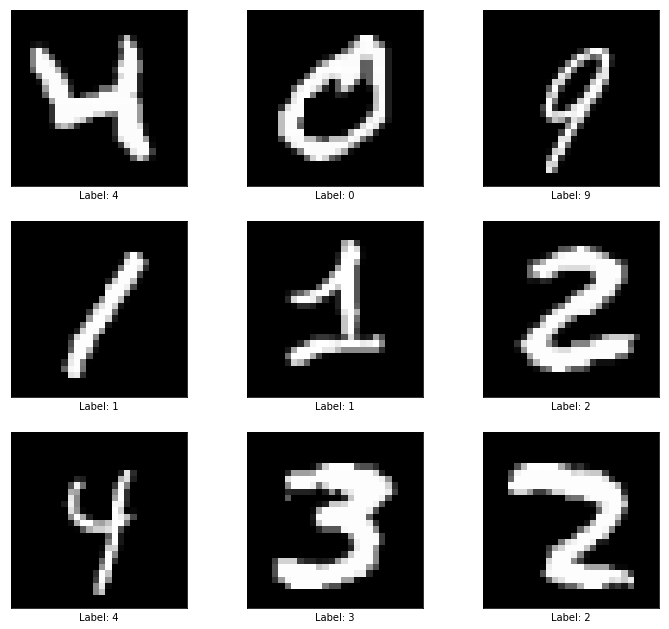

In [114]:
plot_examples(X_train[20:29, :, :, 0], y_train[20:30])

### Defining the Model

We'll need to set up the pieces of the spatial transformer module, and then plug it into a standard CNN.

First, we'll define the **localizer**.
Remember that this is really the same as a small CNN. In a naive approach, I'm simply putting some parameters at the end, forced into a **sigmoid activation**, without concern for their meaning within a transformation matrix...

I'll also define a **standard cnn** for classification.
This will help later for comparing STN results to regular networks, as it will serve as both a stand alone CNN, and as the CNN we feed the output of the Spatial Transformer into.

In [115]:
def localizer(input_layer, constraints):
    if constraints is not None:
        num_params = constraints.num_free_params
    else:
        num_params = 6
    graph = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(input_layer)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(graph)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(graph)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Flatten()(graph)
    theta = keras.layers.Dense(units=num_params, activation='sigmoid')(graph)

    return theta


def cnn_model_fn(input_layer, dense_units, num_classes):
    graph = input_layer
    for i in range(2):
        graph = keras.layers.Conv2D(filters=32 * 2**i, kernel_size=(3, 3), activation='relu')(graph)
        graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Flatten()(graph)
    graph = keras.layers.Dense(
        units=dense_units, activation='sigmoid')(graph)
    dense = keras.layers.Dense(num_classes)(graph)
    logits = keras.layers.Activation('softmax', name='y')(dense)
    
    return logits

def standard_cnn(**pm):
    X = keras.layers.Input(
        shape=pm['input_shape'], name='X')
    output = cnn_model_fn(X, pm['dense_units'], pm['num_classes'])
    model = keras.Model(inputs=X, outputs=output)
    opt = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model


Next, we'll define a special module, using Deepmind Sonnet's tensorflow package.
This module, which I'm calling the Spatial Transform Layer, is meant to take care of generating the grid points and the resampling.

I've defined it to accept a tuple of inputs: the input image, and the transform parameters (the output layer of the localization network). The tuple input works more seamlessly with keras.

In [8]:
class SpatialTransformLayer(snt.AbstractModule):
    """
    affine transform layer.
    Constructor requires output_shape, with optional
    constraints and boundary.
    """

    def __init__(self, output_shape,
                 constraints=None,
                 name='stn_layer'):
        """
        :param output_shape: shape of output layer (not including batch size)
        :param constraints: AffineWarpConstraints object from dm-sonnet package
        :param name: layer name
        """
        super().__init__(name=name)
        if constraints is None:
            # default is full affine transform
            constraints = snt.AffineWarpConstraints.no_constraints(num_dim=2)
        self._constraints = constraints
        self._output_shape = output_shape
        self.__name__ = name

    def _build(self, inputs):
        """
        Layer requires a tuple of arguments: an input layer
        and a set of transform parameters.
        """
        U, theta = inputs
        grid = snt.AffineGridWarper(
            source_shape=U.get_shape().as_list()[1:-1],
            output_shape=self._output_shape,
            constraints=self._constraints)(theta)
        V = tf.contrib.resampler.resampler(U, grid, name='resampler')

        return V


finally, we have the tools to finalize the model.
The format is basic, just to take inputs and transform them.

In [9]:
# define our keras model
def stn_model_fn(**pm):

    # input layer
    U = keras.layers.Input(
        shape=pm['input_shape'], name='X')

    # create localizationnetwork
    theta = localizer(U, pm['constraints'])

    grid_resampler = SpatialTransformLayer(output_shape=pm['output_shape'],
                                           constraints=pm['constraints'])

    # feed input U and parameters theta into the grid resampler
    V = keras.layers.Lambda(
        grid_resampler, output_shape=pm['output_shape'], name='V')([U, theta])

    # now input V to a standard cnn
    logits = cnn_model_fn(V, pm['dense_units'], pm['num_classes'])
    
    model = keras.Model(inputs=U, outputs=logits)
    opt = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return model


# create some boundaries on the affine warp
constraints = snt.AffineWarpConstraints([[None, None, None],
                                         [None, None, None]])

model_parameters = {
    'input_shape': (28, 28, 1),
    'batch_size': 32,
    'output_shape': (28, 28),
    'constraints': constraints,
    'dense_units': 128,
    'num_classes': 10
}


## Testing the Models

Now that we've written up the models themselves, let's initialize each a **Standard CNN** and a **Spatial Transformer Module hooked up to a Standard CNN**

Since the CNNs have the same basic architecture, we expect to see how STNs may change what goes in, and hopefully, get a glimpse of how they change kernels of the model later.


In [10]:
K.clear_session()

In [11]:
normal_model = standard_cnn(**model_parameters)
normal_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.2383 - acc: 0.9447 - val_loss: 0.0709 - val_acc: 0.9792
Epoch 2/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.0668 - acc: 0.9811 - val_loss: 0.0574 - val_acc: 0.9834
Epoch 3/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.0621 - acc: 0.9815 - val_loss: 0.0627 - val_acc: 0.9800
Epoch 4/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.0584 - acc: 0.9823 - val_loss: 0.0626 - val_acc: 0.9809
Epoch 5/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.0586 - acc: 0.9824 - val_loss: 0.0556 - val_acc: 0.9833
Epoch 6/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.0540 - acc: 0.9833 - val_loss: 0.0510 - val_acc: 0.9836
Epoch 7/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.0553 - acc: 0.9824 - val_loss: 0.0569 - val_acc

In [17]:
model = stn_model_fn(**model_parameters)
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.4588 - acc: 0.8445 - val_loss: 0.2999 - val_acc: 0.8877
Epoch 2/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.2737 - acc: 0.8949 - val_loss: 0.2636 - val_acc: 0.8932
Epoch 3/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.2459 - acc: 0.9061 - val_loss: 0.2312 - val_acc: 0.9068
Epoch 4/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.2393 - acc: 0.9077 - val_loss: 0.2605 - val_acc: 0.8982
Epoch 5/10
60000/60000 [==============================] - 7s 113us/step - loss: 0.2279 - acc: 0.9120 - val_loss: 0.2200 - val_acc: 0.9163
Epoch 6/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.2219 - acc: 0.9146 - val_loss: 0.2207 - val_acc: 0.9138
Epoch 7/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.2186 - acc: 0.9138 - val_loss: 0.2340 - 

In [18]:
resampler = keras.Model(inputs=model.input,
                        outputs=model.get_layer('V').output)

### What is the STN getting wrong?

We end up with 95% accuracy in the STN and 98% accuracy in the standard CNN.  So what gives?

I should take this time to note, the accuracy of the STN was quite random, indicating a serious problem with initialization, quite frequently it was near chance, 10%.  *Can you guess why?*

let's look at some examples where the STN is having trouble classifying, to see what might be going on.

In [19]:
# some samples
y_pred = model.predict(X_test)
cls_pred = np.argmax(y_pred, axis=0)
cls_true = np.argmax(y_test, axis=0)

In [21]:
bad_preds = np.argwhere(cls_pred != cls_true).flatten()

In [22]:
examples = bad_preds[:9]
U_images = X_test[examples]
V_images = resampler.predict(U_images)

9


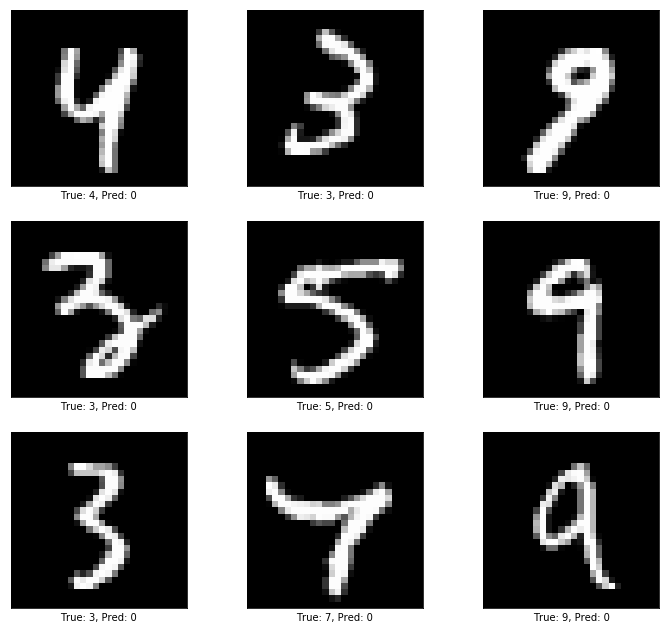

In [23]:
plot_examples(U_images, cls_true[examples], cls_pred[examples])

9


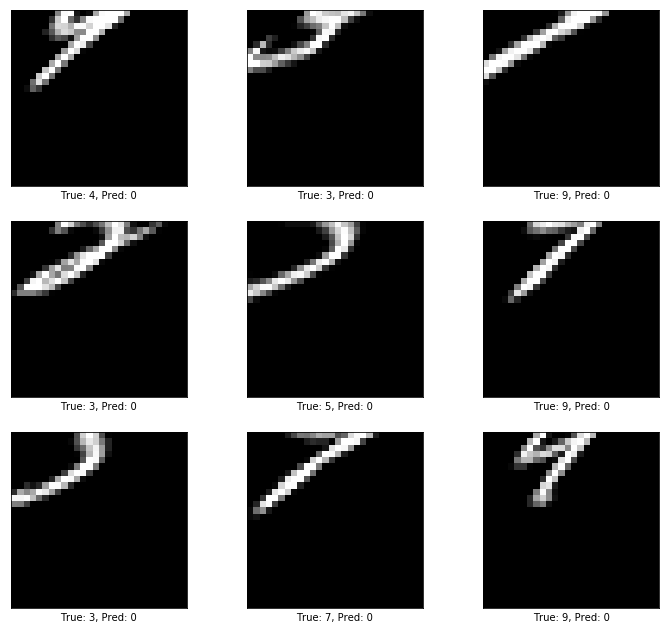

In [24]:
plot_examples(V_images, cls_true[examples], cls_pred[examples])

## The Localizer Network is more nuanced than the paper admits

The authors don't make any statements about just how sensitive these layers are. Think about it:  Out of all the possible transformations, there are *a lot of them* that actually land outside of the original image entirely, or grab a useless zero region in the MNIST case.


In [92]:
def localizer(input_layer, constraints):
    if constraints is not None:
        num_params = constraints.num_free_params
    else:
        num_params = 6
    graph = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid')(input_layer)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid')(graph)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid')(graph)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Flatten()(graph)
    # hard code the affine transformation!
    theta = keras.layers.Dense(units=num_params, activation='tanh', bias_initializer='zeros', activity_regularizer='l2')(graph)
    def add(theta):        
        identity = tf.constant([[1, 0, 0, 0, 1, 0]], dtype=tf.float32)
        theta = theta + identity
        return theta
    
    theta = keras.layers.Lambda(add)(theta)
    print(theta)
    return theta

In [93]:
model = stn_model_fn(**model_parameters)
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Tensor("lambda_78/add:0", shape=(?, 6), dtype=float32)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.4383 - acc: 0.8941 - val_loss: 0.1540 - val_acc: 0.9625
Epoch 2/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1506 - acc: 0.9646 - val_loss: 0.0938 - val_acc: 0.9782
Epoch 3/10
60000/60000 [==============================] - 7s 125us/step - loss: 0.1083 - acc: 0.9741 - val_loss: 0.0786 - val_acc: 0.9824
Epoch 4/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.0912 - acc: 0.9772 - val_loss: 0.0750 - val_acc: 0.9803
Epoch 5/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0726 - acc: 0.9806 - val_loss: 0.0659 - val_acc: 0.9833
Epoch 6/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0563 - acc: 0.9841 - val_loss: 0.0499 - val_acc: 0.9847
Epoch 7/10
60000/60000 [==============================] - 7s 124us

Let's see what this new model is having trouble with...

In [102]:
# some samples
y_pred = model.predict(X_test)
cls_pred = np.argmax(y_pred, axis=1)
cls_true = np.argmax(y_test, axis=1)

In [110]:
bad_preds = np.argwhere(cls_pred != cls_true).flatten()
examples = bad_preds[:9]
U_images = X_test[examples]
V_images = resampler.predict(U_images)

9


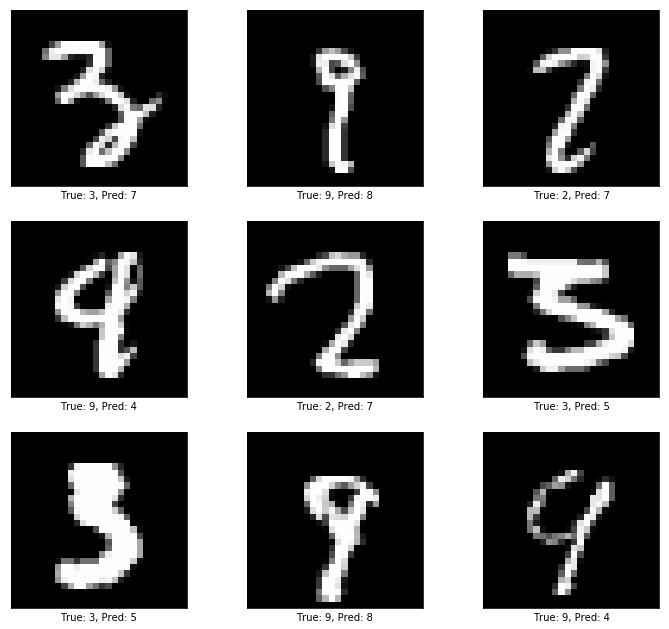

In [116]:
plot_examples(U_images, cls_true[examples], cls_pred[examples])

9


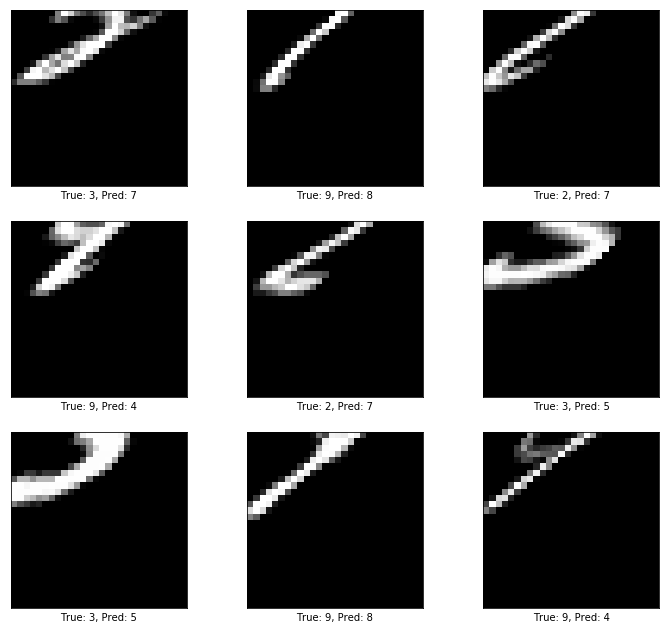

In [117]:
plot_examples(V_images, cls_true[examples], cls_pred[examples])

In [ ]:
U_images = X_test[:9]
V_images = resampler.predict(U_images)

In [107]:
cls_pred[examples].shape

(9,)